# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Import tensorflow dependencies - Functional API
from keras import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\e6d67ff8-4746-11ef-9cc5-8c882b60f0e6.jpg'

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250pxqq
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

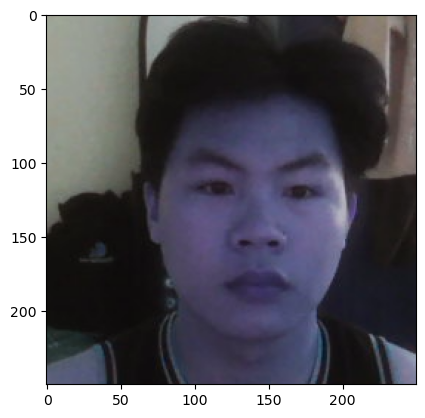

In [9]:
frame = cv2.resize(frame, (250, 250))  # Resize to 250x250
plt.imshow(frame)
plt.show()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\5bd84c31-2d49-11ef-8172-8c882b60f0e6.jpg'


## 3.2 Preprocessing - Scale and Resize

In [13]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [14]:
img = preprocess('data\\anchor\\5bd84c31-2d49-11ef-8172-8c882b60f0e6.jpg')

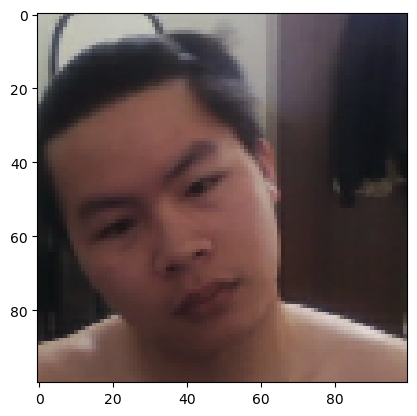

In [15]:
plt.imshow(img)

In [16]:
img.numpy().max() 

0.88553923

## 3.3 Create Labelled Dataset

In [148]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
exampple = samples.next()

In [20]:
exampple

(b'data\\anchor\\56389c54-2d49-11ef-8d1d-8c882b60f0e6.jpg',
 b'data\\positive\\8db56e9c-2d49-11ef-933a-8c882b60f0e6.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [22]:
res = preprocess_twin(*exampple)

In [22]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.73357844, 0.75710785, 0.7022059 ],
         [0.7321078 , 0.7526961 , 0.7105392 ],
         [0.7343137 , 0.74607843, 0.71862745],
         ...,
         [0.19117647, 0.18333334, 0.26862746],
         [0.19436274, 0.19534314, 0.2747549 ],
         [0.19705883, 0.2009804 , 0.27941176]],
 
        [[0.73014706, 0.7536765 , 0.7007353 ],
         [0.7296569 , 0.7502451 , 0.7120098 ],
         [0.7323529 , 0.7441176 , 0.7147059 ],
         ...,
         [0.17794117, 0.17524509, 0.25588235],
         [0.18333334, 0.1872549 , 0.26421568],
         [0.1882353 , 0.19215687, 0.2627451 ]],
 
        [[0.7323529 , 0.7470588 , 0.7088235 ],
         [0.73088235, 0.74485296, 0.7088235 ],
         [0.7272059 , 0.7389706 , 0.69779414],
         ...,
         [0.16691177, 0.17083333, 0.24338235],
         [0.18039216, 0.18431373, 0.25539216],
         [0.18235295, 0.18921569, 0.2509804 ]],
 
        ...,
 
        [[0.5473039 , 0.4090686 

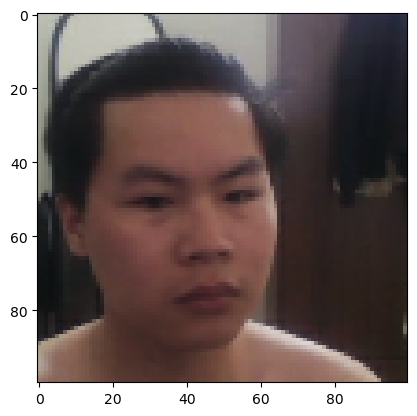

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
samples=data.as_numpy_iterator()

In [27]:
len(samples.next())

3

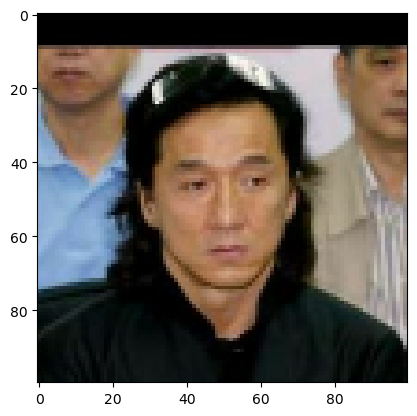

In [28]:
samp = samples.next()
plt.imshow(samp[1])

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [31]:
inp = Input(shape=(100,100,3), name='input_image')

In [32]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)

In [33]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [34]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [35]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [36]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    # return Model(inputs=[inp], outputs=[d1], name='embedding')
    return Model(inputs=inp, outputs=d1, name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [42]:
class L1Dist(Layer):

# Magic happens here - similarity calculation
    # def call(self, input_embedding, validation_embedding):
    def call(self, inputs):
        # return tf.math.abs(input_embedding - validation_embedding)
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)


## 4.3 Make Siamese Model

In [43]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))


In [44]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [45]:
siamese_layer = L1Dist()

In [46]:
# distances = siamese_layer(embedding(input_image), embedding(validation_image))
distances = siamese_layer([embedding(input_image), embedding(validation_image)])

In [47]:
classifier = Dense(1, activation='sigmoid')(distances)

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [49]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [51]:
siamese_model = make_siamese_model()

In [52]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [54]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [55]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [57]:
checkpoint_dir = './training_checkpoints3'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [61]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [62]:
y = batch_1[2]

In [63]:
y

array([1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [1]:
tf.losses.BinaryCrossentropy??

NameError: name 'tf' is not defined

In [64]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    global loss
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [68]:
EPOCHS = 50

In [69]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

# 6. Evaluate Model

## 6.1 Import Metrics

In [57]:
# Import metric calculations
# from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [70]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [71]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [72]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


array([[1.5385450e-04],
       [9.9782479e-01],
       [1.1044066e-07],
       [1.0000000e+00],
       [2.4268417e-12],
       [9.9769855e-01],
       [1.9846727e-10],
       [9.9930686e-01],
       [9.9999994e-01],
       [5.4883903e-11],
       [6.2971020e-07],
       [2.8305953e-08],
       [2.8471424e-12],
       [9.9998242e-01],
       [1.8179730e-13],
       [6.0459358e-13]], dtype=float32)

In [73]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [74]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [75]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [77]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1.0 1.0


## 6.4 Viz Results

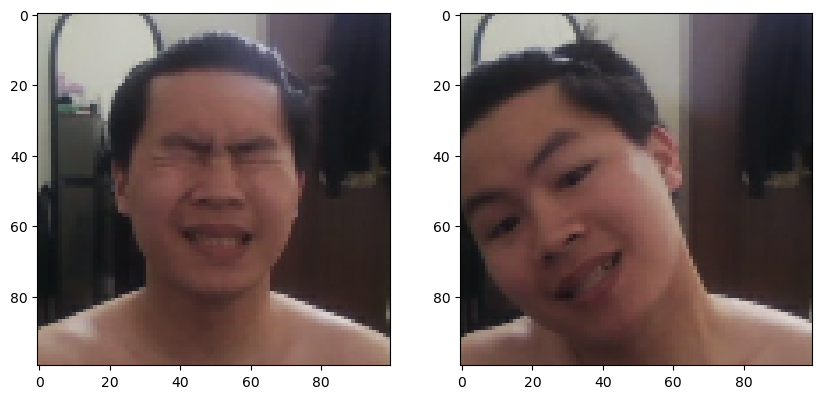

In [78]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [79]:


siamese_model.save('my_model4.keras')

In [53]:
L1Dist

__main__.L1Dist

In [54]:
# Reload model 
siamese_model = tf.keras.models.load_model('my_model4.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [55]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

In [56]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [410]:
# application_data\verification_images

SyntaxError: unexpected character after line continuation character (4081098762.py, line 1)

In [57]:
os.listdir(os.path.join('application_data', 'verification_images'))

['01a2dd5c-2c0b-11ef-8a2c-8c882b60f0e6.jpg',
 '01d04843-2c0b-11ef-9efb-8c882b60f0e6.jpg',
 '02c1f880-2c0b-11ef-8e30-8c882b60f0e6.jpg',
 '02f42719-2c0b-11ef-a6be-8c882b60f0e6.jpg',
 '03c28648-2c0b-11ef-b8db-8c882b60f0e6.jpg',
 '03eff1af-2c0b-11ef-a4dc-8c882b60f0e6.jpg',
 '04a03ff7-2c0b-11ef-a324-8c882b60f0e6.jpg',
 '04c893e9-2c0b-11ef-a0ed-8c882b60f0e6.jpg',
 '04fffa8c-2c0b-11ef-8f4a-8c882b60f0e6.jpg',
 '0a584229-2c0b-11ef-b058-8c882b60f0e6.jpg',
 '0a80a314-2c0b-11ef-985f-8c882b60f0e6.jpg',
 '0aae0dce-2c0b-11ef-aacc-8c882b60f0e6.jpg',
 '0b6829d2-2c0b-11ef-9c29-8c882b60f0e6.jpg',
 '0bc2cace-2c0b-11ef-9e2d-8c882b60f0e6.jpg',
 '0bedf998-2c0b-11ef-bc1c-8c882b60f0e6.jpg',
 '0bf54833-2c0b-11ef-bbb5-8c882b60f0e6.jpg',
 '0c68caab-2c0b-11ef-ac53-8c882b60f0e6.jpg',
 '0c966e48-2c0b-11ef-93c2-8c882b60f0e6.jpg',
 '0cc87842-2c0b-11ef-92f0-8c882b60f0e6.jpg',
 '0cfad9e6-2c0b-11ef-8fd0-8c882b60f0e6.jpg',
 '0d28559d-2c0b-11ef-8cec-8c882b60f0e6.jpg',
 '0d5aa9f9-2c0b-11ef-bcd3-8c882b60f0e6.jpg',
 '0e12fdfa

In [58]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [ ]:
# lay data anh khi chua co(su dung con detect)
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250pxqq
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('c'):
        # Create the unique file path 
        validation_img_check = os.path.join(ANC_PATH, 'application_data', 'verification_images'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(validation_img_check, frame)
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [59]:
#so sanh anh co san 
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\01a2dd5c-2c0b-11ef-8a2c-8c882b60f0e6.jpg
application_data\verification_images\01d04843-2c0b-11ef-9efb-8c882b60f0e6.jpg
application_data\verification_images\02c1f880-2c0b-11ef-8e30-8c882b60f0e6.jpg
application_data\verification_images\02f42719-2c0b-11ef-a6be-8c882b60f0e6.jpg
application_data\verification_images\03c28648-2c0b-11ef-b8db-8c882b60f0e6.jpg
application_data\verification_images\03eff1af-2c0b-11ef-a4dc-8c882b60f0e6.jpg
application_data\verification_images\04a03ff7-2c0b-11ef-a324-8c882b60f0e6.jpg
application_data\verification_images\04c893e9-2c0b-11ef-a0ed-8c882b60f0e6.jpg
application_data\verification_images\04fffa8c-2c0b-11ef-8f4a-8c882b60f0e6.jpg
application_data\verification_images\0a584229-2c0b-11ef-b058-8c882b60f0e6.jpg
application_data\verification_images\0a80a314-2c0b-11ef-985f-8c882b60f0e6.jpg
application_data\verification_images\0aae0dce-2c0b-11ef-aacc-8c882b60f0e6.jpg
application_data\verification_images\0b6829d2-2c0b-11ef-9c29-8c8

In [87]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        #validation_img_check = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [93]:

results, verified = verify(siamese_model, 0.9, 0.7)
print(verified)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

In [94]:
np.sum(np.squeeze(results) > 0.9)

0

In [112]:
results

[array([[0.47735217]], dtype=float32),
 array([[0.8521728]], dtype=float32),
 array([[0.99994326]], dtype=float32),
 array([[0.99991524]], dtype=float32),
 array([[0.0510204]], dtype=float32),
 array([[0.09285117]], dtype=float32),
 array([[0.87997204]], dtype=float32),
 array([[0.18446875]], dtype=float32),
 array([[0.9871775]], dtype=float32),
 array([[0.99977237]], dtype=float32),
 array([[0.9988329]], dtype=float32),
 array([[0.9592792]], dtype=float32),
 array([[0.99923944]], dtype=float32),
 array([[0.999939]], dtype=float32),
 array([[0.9989855]], dtype=float32),
 array([[0.9989855]], dtype=float32),
 array([[0.99995965]], dtype=float32),
 array([[0.9999504]], dtype=float32),
 array([[0.94274795]], dtype=float32),
 array([[0.9930928]], dtype=float32),
 array([[0.0209549]], dtype=float32),
 array([[0.9887864]], dtype=float32),
 array([[0.98673964]], dtype=float32),
 array([[0.99292684]], dtype=float32),
 array([[0.992246]], dtype=float32),
 array([[0.9788675]], dtype=float32),
 a

In [ ]:
#face detection

In [91]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━